# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa as lb
import librosa.display
import pickle
import glob
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

Pada notebook ini, dilakukan beberapa hal yaitu:


1.Ekstraksi Fitur MFCC

Melakukan ekstraksi fitur pada semua subset (train, test, val).


2.Normalisasi MFCC

Normalisasi fitur menggunakan parameter yang dihitung dari data train.

3.Label Encoding

4.Probabilistic Neural Network

Pelaksanaan klasifikasi penyakit berdasarkan eksraksi fitur yang diperoleh.

In [2]:
data = pd.read_csv("updated_data.csv")
data.head()

,awal,akhir,crackles,wheezes,pid,mode,namafile,diagnosa
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron_0,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron_1,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron_2,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron_3,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron_4,URTI


In [3]:
y_data = data.diagnosa
y_data

,diagnosa
0,URTI
1,URTI
2,URTI
3,URTI
4,URTI
...,...
6893,Pneumonia
6894,Pneumonia
6895,Pneumonia
6896,Pneumonia


### MFCC

In [4]:
# Fungsi Pre-emphasis
def pre_emphasize(signal, pre_emphasis=0.97):
    return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [ ]:
# Fungsi untuk ekstraksi fitur
def get_features(path):
    y, sr = lb.load(path, sr=None)

    # Pre-emphasis
    emphasized_audio = pre_emphasize(y)

    # Mel Spectrogram dari windowed frames
    mel_spec = lb.feature.melspectrogram(y=emphasized_audio, sr=sr, n_mels=40, fmax=sr//2)

    # Konversi ke dB dengan referensi yang lebih stabil
    mel_spec_db = lb.power_to_db(mel_spec, ref=np.max)

    # Hitung MFCC dari Mel Spectrogram dalam skala dB
    mfcc = lb.feature.mfcc(S=mel_spec_db, sr=sr, n_mfcc=20, dct_type=2)

    return mfcc, mel_spec_db

In [9]:
# Ekstraksi fitur dengan batch processing
def extract_and_save_features_batch(metadata, root_dir, save_dir, batch_size=1000):
    os.makedirs(save_dir, exist_ok=True)

    batch_index = 0

    for start in range(0, len(metadata), batch_size):
        batch_metadata = metadata.iloc[start:start + batch_size]
        mfcc_data, labels = [], []

        for idx, row in batch_metadata.iterrows():
            audio_path = os.path.join(root_dir, f"{row['namafile']}.wav")
            try:
                mfcc, mel_spec_db = get_features(audio_path)
                label = row['diagnosa']
                mfcc_data.append(mfcc)
                labels.append(label)

            except FileNotFoundError as e:
                print(f"File tidak ditemukan: {e}")

        # Simpan setiap batch ke file
        with open(os.path.join(save_dir, f"mfcc_data_batch_{batch_index}.pkl"), "wb") as f:
            pickle.dump(np.array(mfcc_data), f)
        with open(os.path.join(save_dir, f"labels_batch_{batch_index}.pkl"), "wb") as f:
            pickle.dump(labels, f)

        print(f"Batch {batch_index} berhasil disimpan di folder {save_dir}")
        batch_index += 1

    print("Semua batch selesai diproses.")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
root_dir = "/content/drive/MyDrive/Udayana/Skripsi/Codes/normalized_audio"
save_dir_data = "hasil_mfcc"

In [ ]:
# Eksekusi ekstraksi fitur
extract_and_save_features_batch(data, root_dir, save_dir_data, batch_size=1000)

Batch 0 berhasil disimpan di folder hasil_mfcc
Batch 1 berhasil disimpan di folder hasil_mfcc
Batch 2 berhasil disimpan di folder hasil_mfcc
Batch 3 berhasil disimpan di folder hasil_mfcc
Batch 4 berhasil disimpan di folder hasil_mfcc
Batch 5 berhasil disimpan di folder hasil_mfcc
Batch 6 berhasil disimpan di folder hasil_mfcc
Semua batch selesai diproses.


In [ ]:
def merge_batches(save_dir, output_file_name, is_label=False):
    pattern = f"{output_file_name}_batch_*.pkl"
    files = sorted(glob.glob(os.path.join(save_dir, pattern)))

    if not files:
        print(f"Tidak ada file ditemukan untuk pola: {pattern}")
        return

    merged_data = []

    for file in files:
        with open(file, "rb") as f:
            batch_data = pickle.load(f)
            if is_label and not isinstance(batch_data, list):
                merged_data.append(batch_data)
            else:
                merged_data.extend(batch_data)

    # Simpan hasil gabungan
    output_path = os.path.join(save_dir, f"{output_file_name}.pkl")
    with open(output_path, "wb") as f:
        pickle.dump(merged_data, f)

    print(f"Data gabungan disimpan di: {output_path}")

In [ ]:
# Panggil fungsi untuk setiap tipe data
merge_batches(save_dir_data, "mfcc_data")
merge_batches(save_dir_data, "labels", is_label=True)

Data gabungan disimpan di: hasil_mfcc/mfcc_data.pkl
Data gabungan disimpan di: hasil_mfcc/labels.pkl


## Resampling Data

In [13]:
# Membaca data tersimpan untuk klasifikasi
def load_saved_features(save_dir):
    with open(os.path.join(save_dir, "mfcc_data.pkl"), "rb") as f:
        mfcc_data = pickle.load(f)
    with open(os.path.join(save_dir, "labels.pkl"), "rb") as f:
        labels = pickle.load(f)
    return mfcc_data, np.array(labels)

In [14]:
# Membaca data tersimpan
mfcc_data, y_data = load_saved_features(save_dir_data)

In [15]:
# Pastikan data diubah menjadi array NumPy
mfcc = np.array(mfcc_data)

In [16]:
print("Dimensi mfcc_data:", mfcc.shape)
print("Dimensi y_data:", y_data.shape)

Dimensi mfcc_data: (6898, 20, 259)
Dimensi y_data: (6898,)


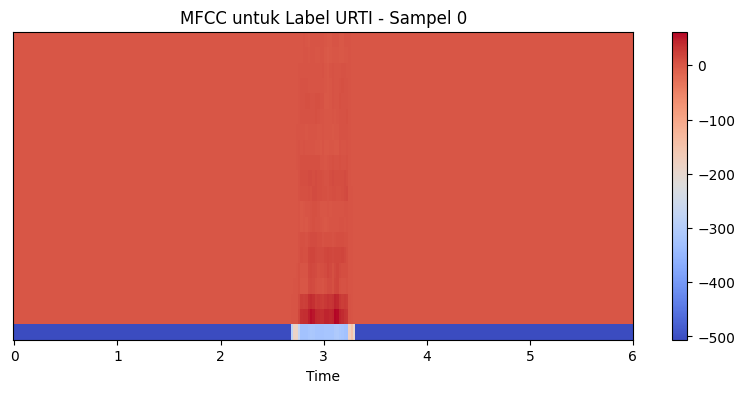

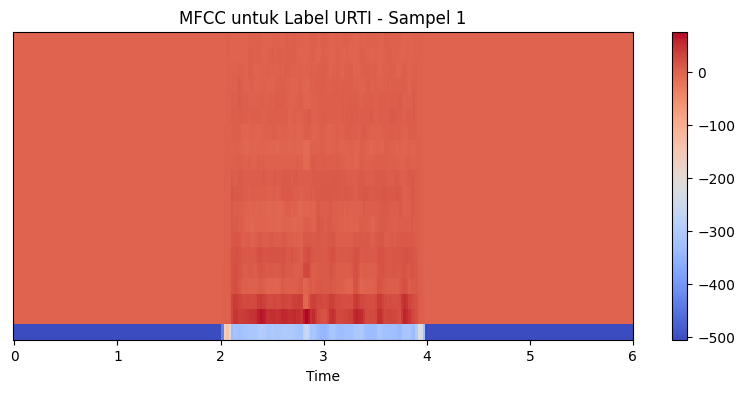

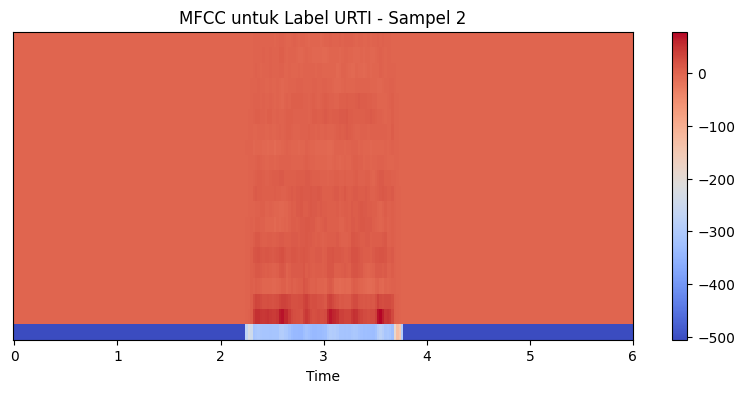

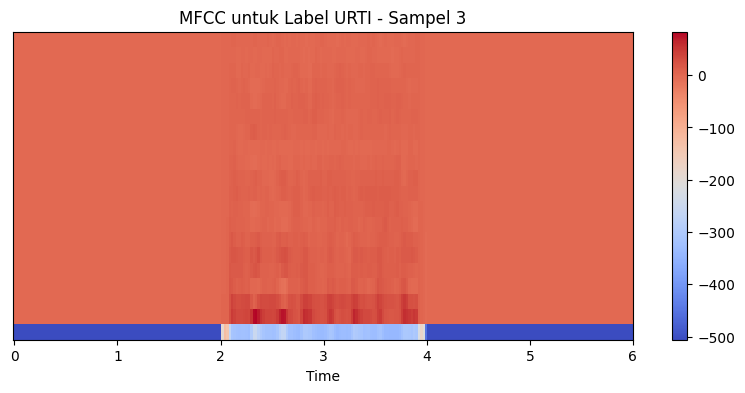

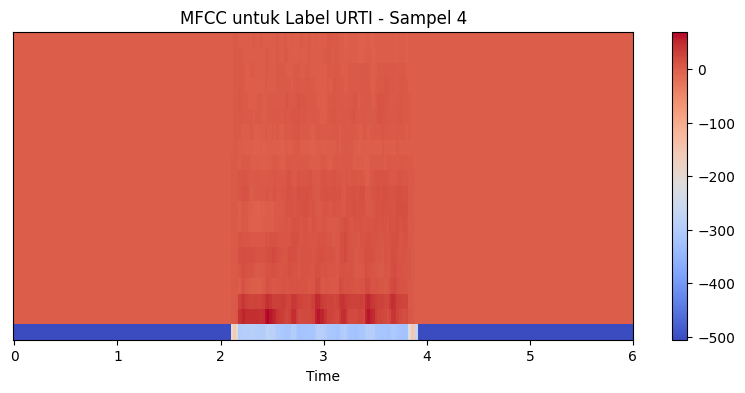

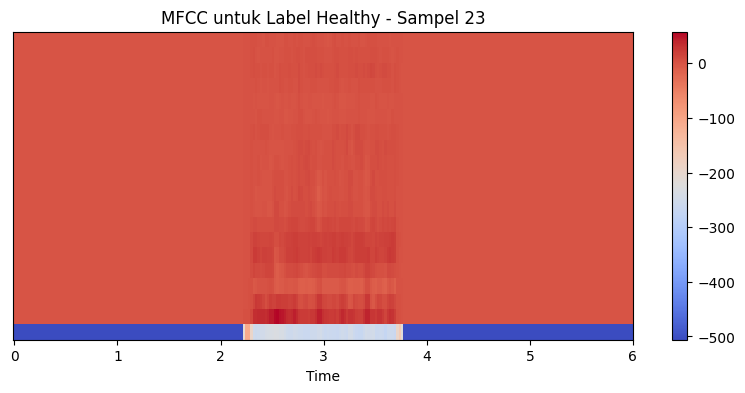

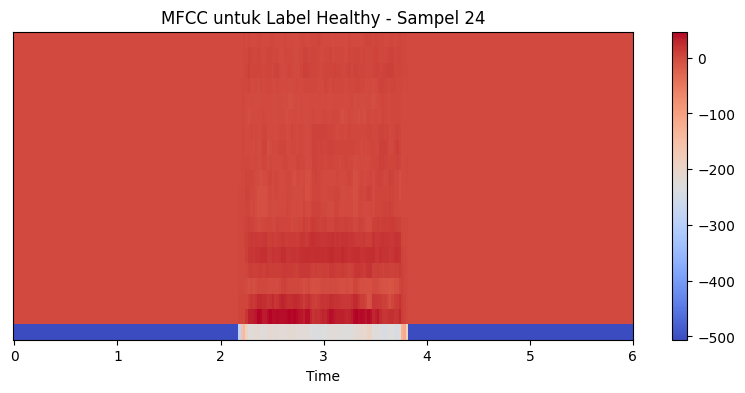

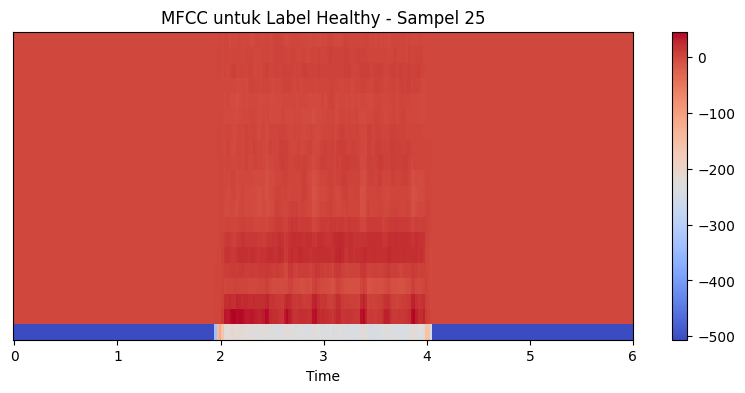

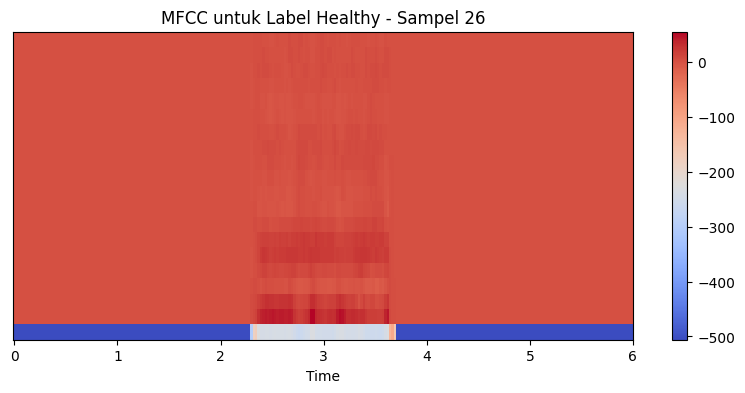

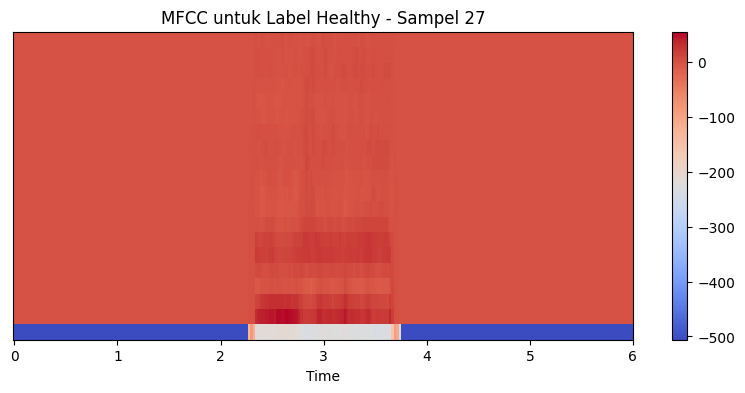

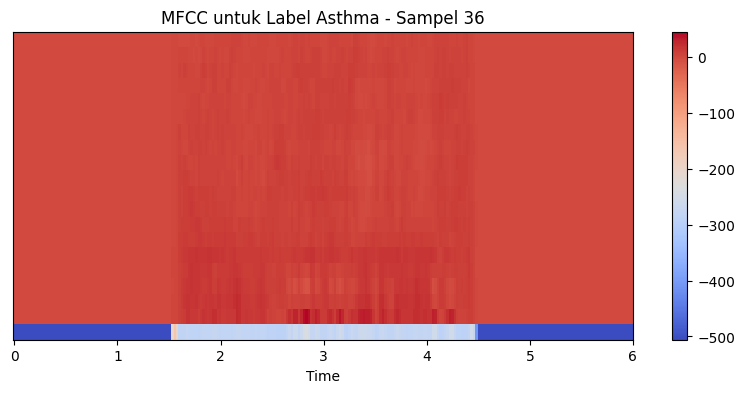

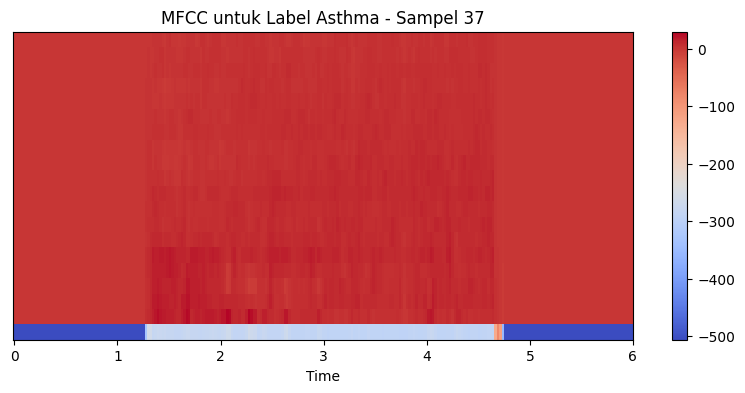

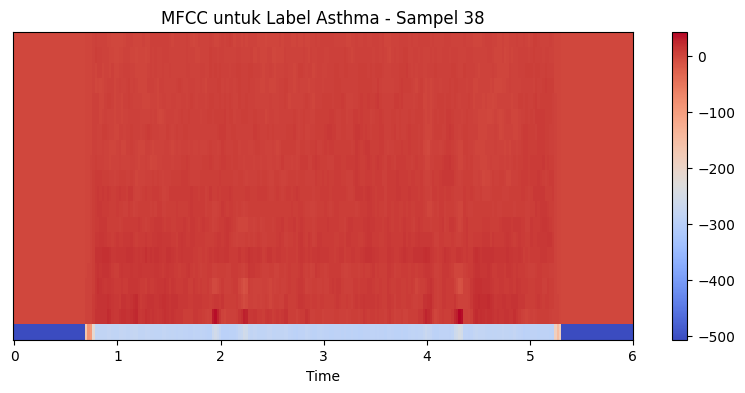

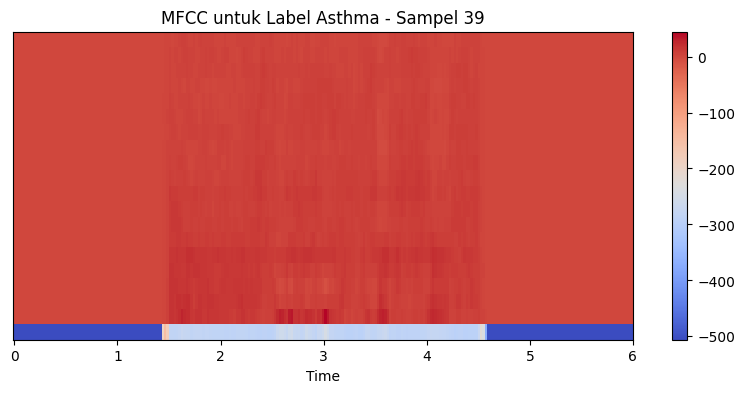

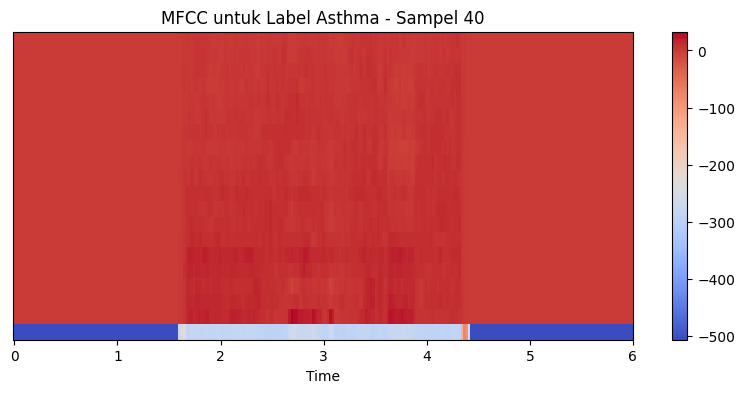

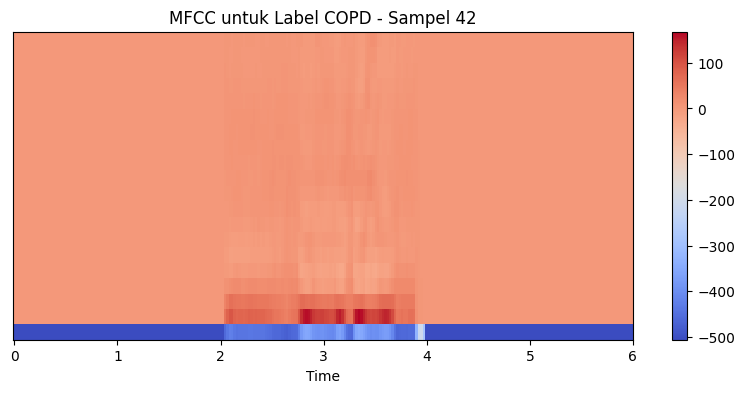

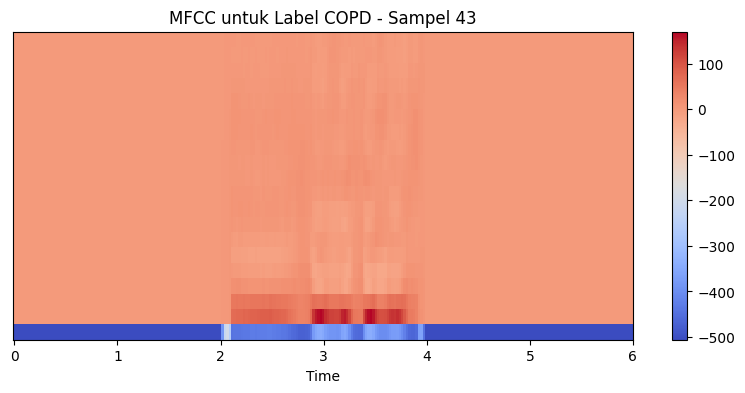

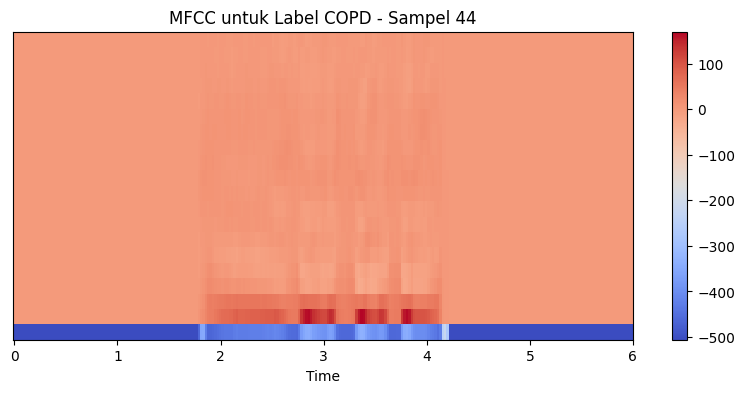

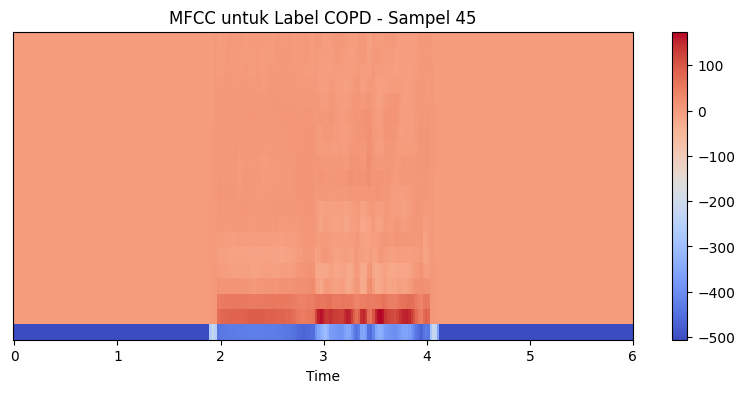

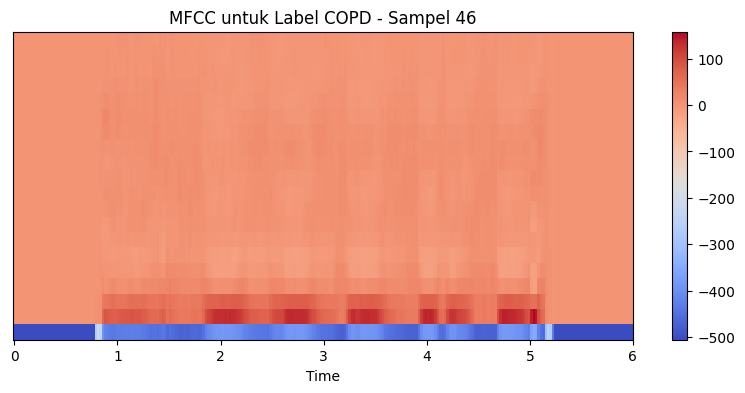

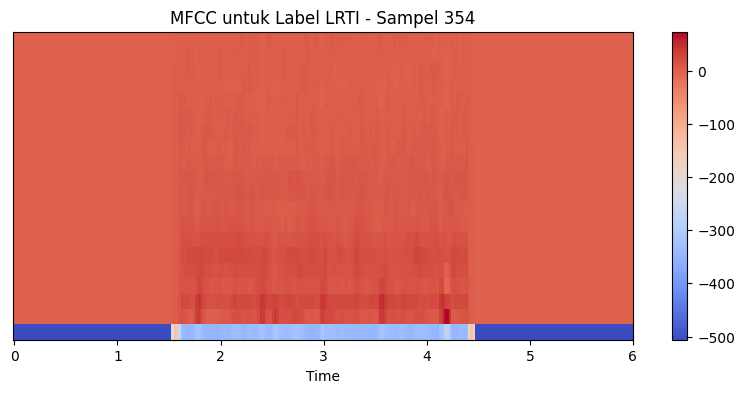

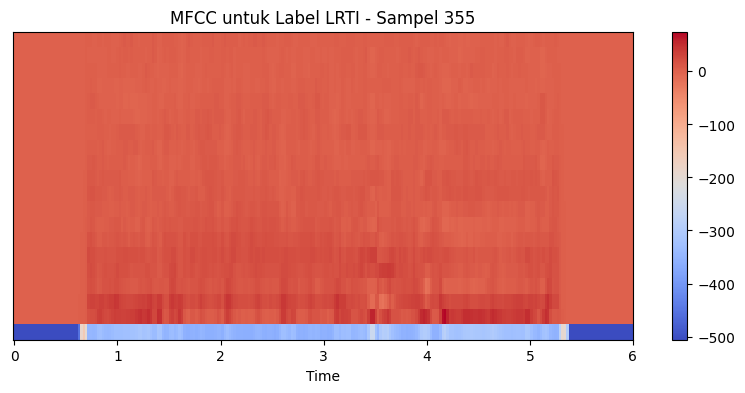

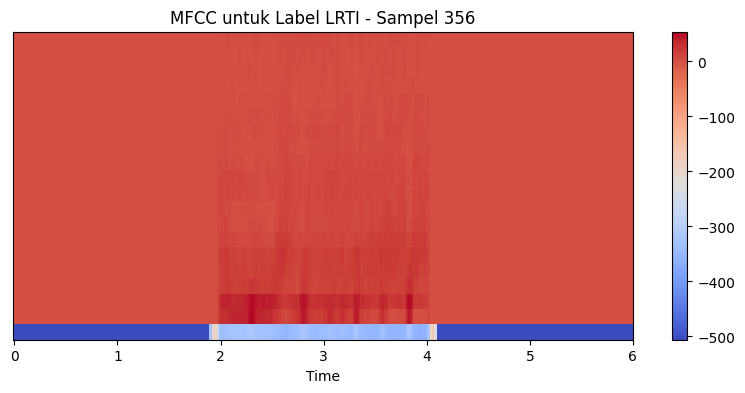

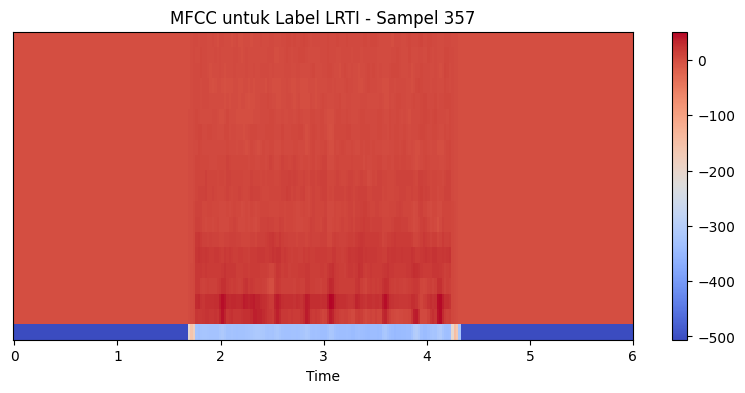

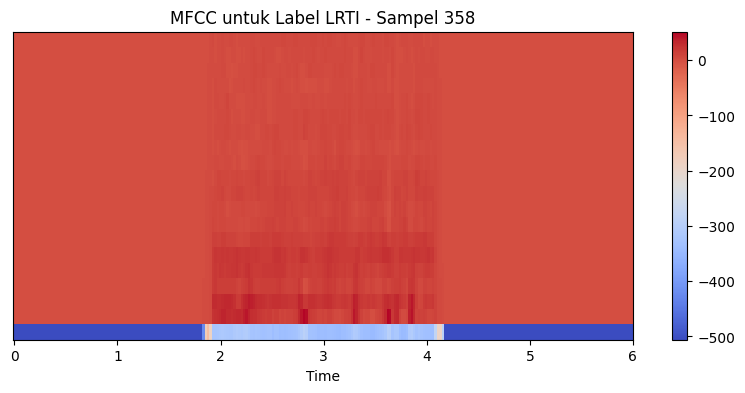

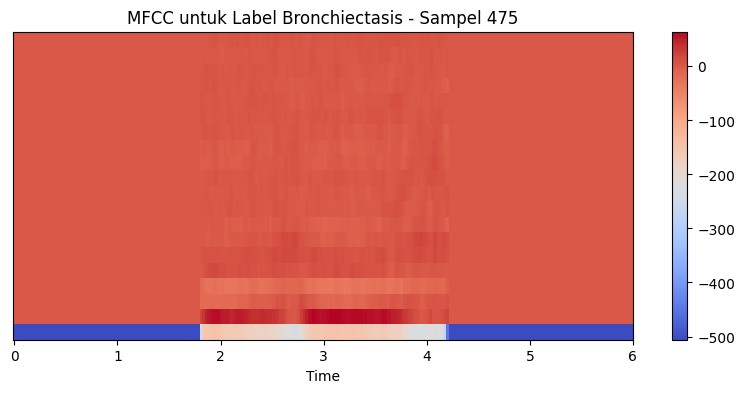

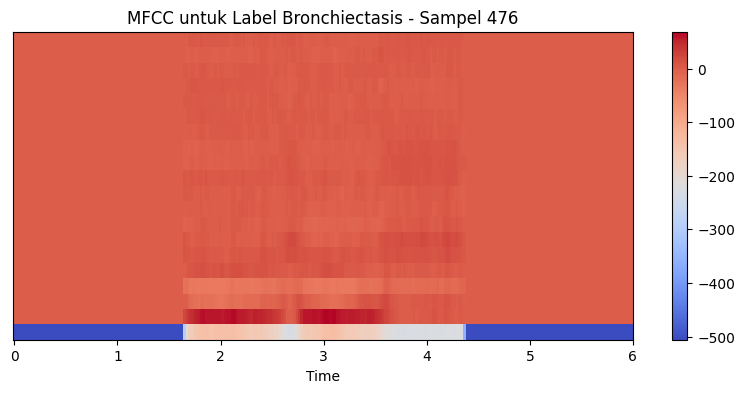

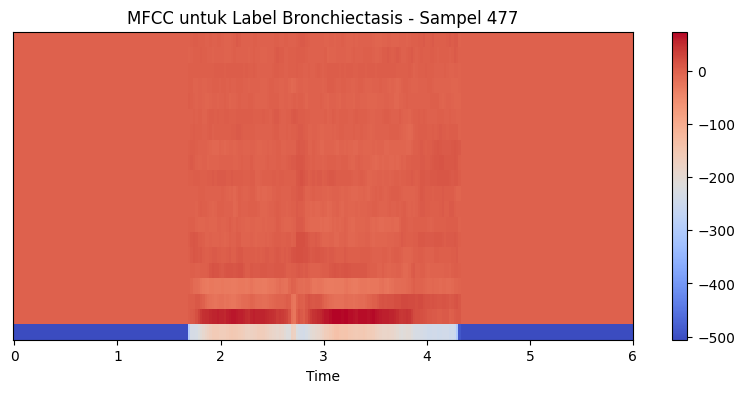

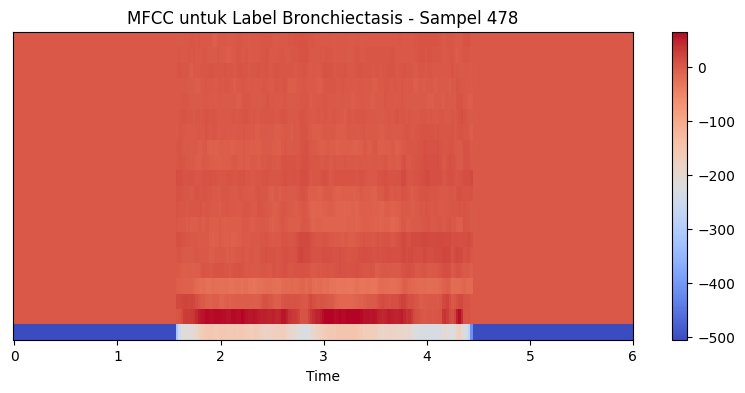

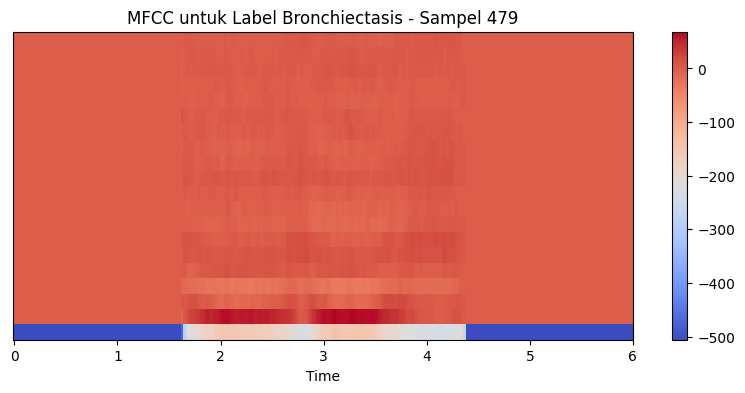

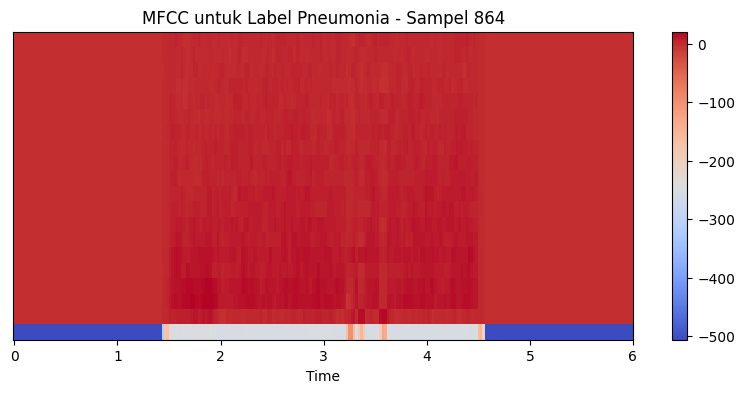

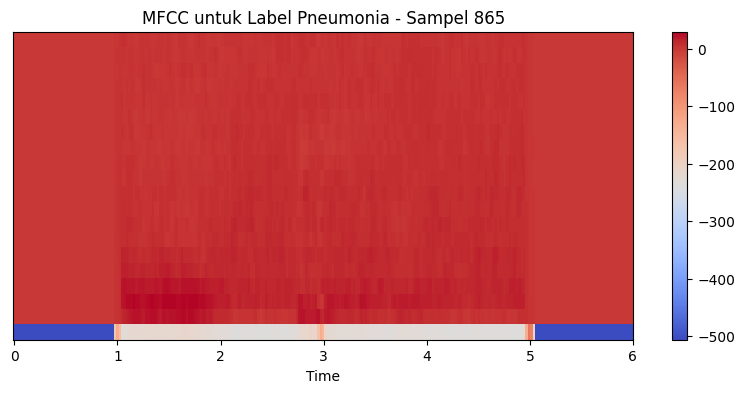

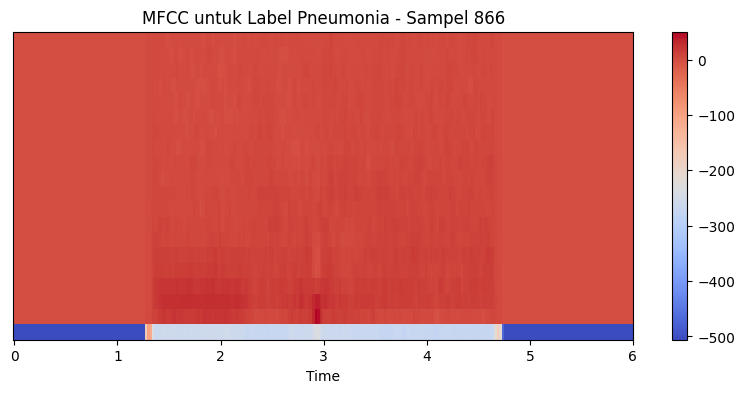

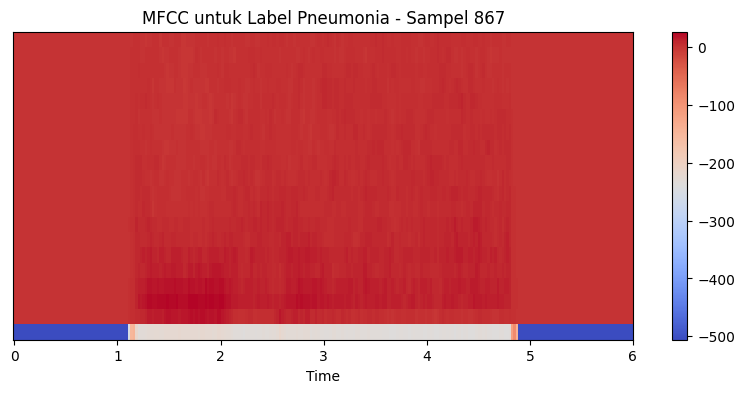

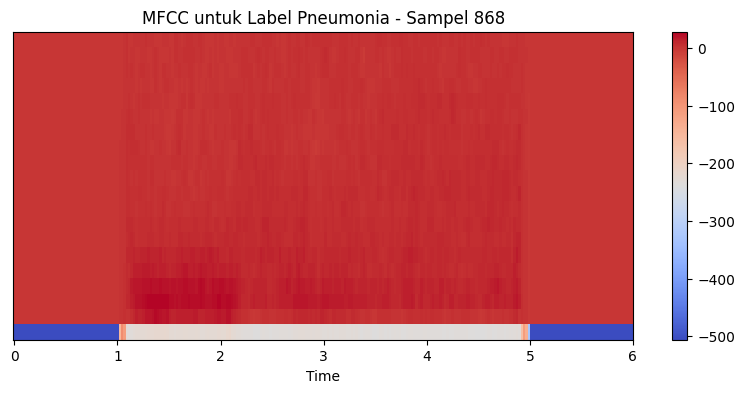

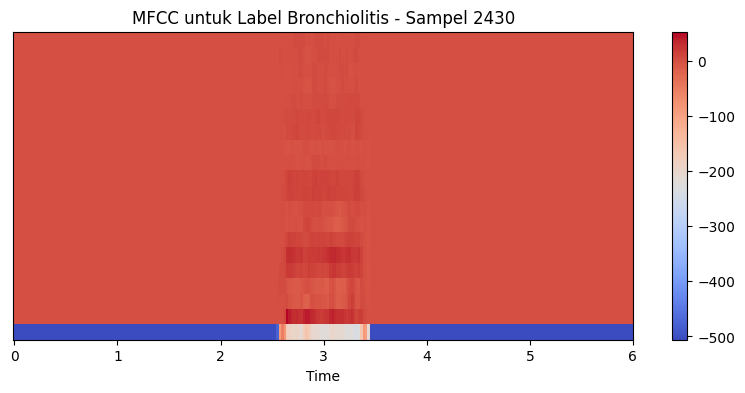

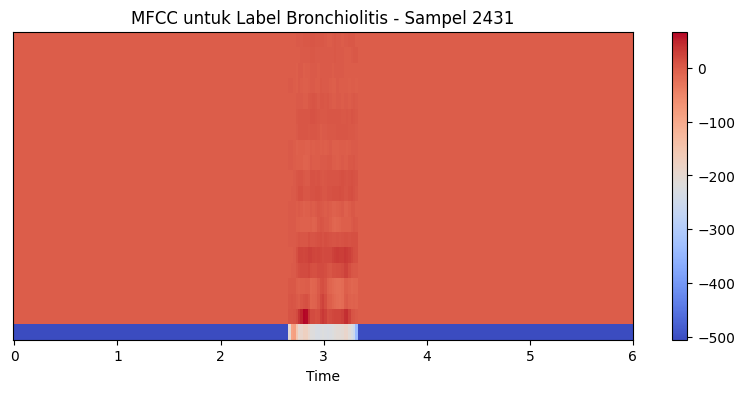

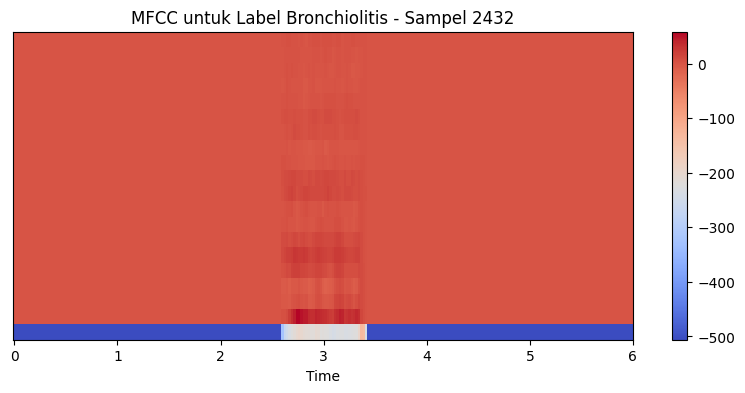

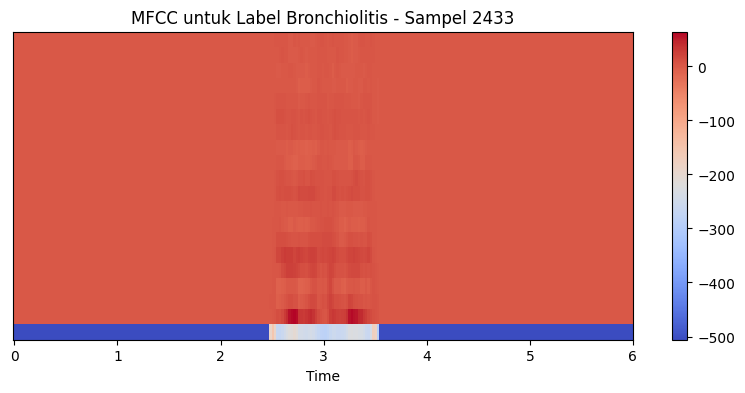

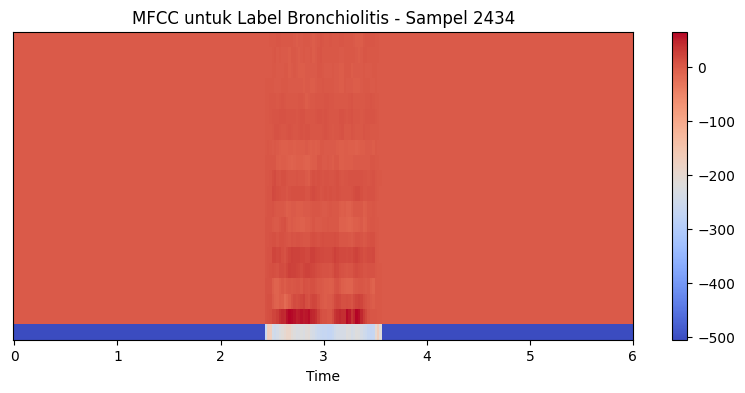

In [17]:
# Menghitung jumlah sampel per label untuk batas visualisasi
label_counts = {}
plot_per_label = 5

# Visualisasi MFCC (5 sampel per label)
for i in range(len(mfcc)):
    label = y_data[i]

    # Cek apakah label sudah mencapai batas plot_per_label
    if label not in label_counts:
        label_counts[label] = 0
    if label_counts[label] >= plot_per_label:
        continue

    label_counts[label] += 1

    # Plot MFCC
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc[i], x_axis="time", cmap="coolwarm")
    plt.colorbar()
    plt.title(f"MFCC untuk Label {label} - Sampel {i}")
    plt.show()

In [ ]:
# Menampilkan bentuk MFCC secara utuh
df_mfcc = pd.DataFrame(mfcc[3])  # Hanya sampel pertama sebagai contoh
print("\nMFCC:")
df_mfcc


MFCC:


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,...,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [75]:
# Menampilkan 20 frame dengan koefisien terbesar
mfcc_librosa = mfcc[3]  # Ambil satu sampel pertama untuk analisis frame

# Cari 20 frame dengan koefisien terbesar
important_frames = np.argsort(np.abs(mfcc_librosa).sum(axis=0))[-20:]

# Urutkan frame berdasarkan nomor frame
important_frames = np.sort(important_frames)

# Ambil hanya frame yang penting
mfcc_important = mfcc_librosa[:, important_frames]

# Ubah ke DataFrame
df_important = pd.DataFrame(mfcc_important, columns=important_frames)

# Tampilkan frame yang dipilih
print("\nMFCC dengan 20 nilai terbesar pada frame:")
df_important


MFCC dengan 20 nilai terbesar pada frame:


,60,63,64,65,66,67,91,92,121,122,131,132,151,152,153,154,155,156,162,163
0,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-505.964417,-313.681580,-319.158478,-301.725708,-304.642090,-320.990906,-311.466064,-332.779633,-321.518555,-316.371277,-330.621826,-338.543976,-339.659027,-319.700195,-306.632263
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.249626,39.418961,60.460880,57.222824,41.868141,52.716278,29.059910,43.789909,47.010887,31.885498,22.764534,19.633423,45.504162,58.987823
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.712456,33.236561,43.680199,42.616795,41.603600,43.591030,32.379547,42.290230,37.963928,31.896547,27.819202,23.987213,43.743725,49.296608
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.700687,12.704334,15.320969,16.346149,15.511204,13.850475,13.982890,22.101395,17.807341,15.628540,13.920462,10.528584,18.346653,19.064438
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.158504,15.076416,16.942204,17.727798,11.372318,9.499365,10.722399,16.035103,16.827131,12.927271,10.407236,10.243221,13.743298,13.236431
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.569397,18.691494,18.524448,18.314779,12.134460,15.454597,11.892138,16.424229,16.882587,13.394007,10.542549,8.926891,15.910208,16.282761
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.927315,12.411014,13.522297,11.308016,10.410611,12.894428,8.218957,10.529469,12.871773,13.535532,12.895471,10.429263,12.829326,15.016459
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.059986,8.749978,4.526403,4.428076,8.341352,9.303913,7.537358,7.537278,8.953686,12.522484,14.536648,11.652670,10.154594,8.645276
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.991633,9.250219,1.029548,1.853604,9.833412,6.545431,10.877708,10.575865,11.023535,11.482589,12.392587,12.807667,8.008051,6.019481
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.356440,11.369428,1.794463,3.529479,10.815436,9.090330,12.111359,11.332070,12.709096,12.766679,11.756730,13.519245,6.008301,5.547369


In [18]:
# Mengubah dimensi menggunakan NumPy
X_data = np.reshape(mfcc, (mfcc.shape[0], -1))

print("Dimensi X_data setelah reshape:", X_data.shape)

Dimensi X_data setelah reshape: (6898, 5180)


In [19]:
# Encode label dan tampilkan mapping-nya
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'Asthma': 0, 'Bronchiectasis': 1, 'Bronchiolitis': 2, 'COPD': 3, 'Healthy': 4, 'LRTI': 5, 'Pneumonia': 6, 'URTI': 7}


In [20]:
# Normalisasi data sebelum resampling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Target maksimum data per label
max_limit = 1500

# Data untuk resampling
X_resampled = []
y_resampled = []

# Loop berdasarkan label
for label in np.unique(y_encoded):
    mask = y_encoded == label
    X_label = X_scaled[mask]
    y_label = y_encoded[mask]

    if len(X_label) > max_limit:
        # Downsampling menggunakan K-Means clustering
        kmeans = KMeans(n_clusters=max_limit, random_state=42)
        kmeans.fit(X_label)
        X_downsampled = kmeans.cluster_centers_
        y_downsampled = [label] * max_limit
        X_resampled.append(X_downsampled)
        y_resampled.extend(y_downsampled)
    elif len(X_label) < max_limit:
        # Oversampling menggunakan resample
        X_oversampled = resample(
            X_label,
            replace=True,
            n_samples=max_limit,
            random_state=42
        )
        y_oversampled = [label] * max_limit
        X_resampled.append(X_oversampled)
        y_resampled.extend(y_oversampled)
    else:
        # Data sudah sesuai max_limit
        X_resampled.append(X_label)
        y_resampled.extend(y_label)

# Gabungkan data hasil resampling
X_resampled = np.vstack(X_resampled)
y_resampled = np.array(y_resampled)

# Lakukan denormalisasi jika diperlukan untuk PNN
X_resampled = scaler.inverse_transform(X_resampled)

print("Resampling selesai.")

Resampling selesai.


## Klasifikasi dengan PNN

Evaluasi dilakukan menggunakan Stratified K-Fold Cross Validation dan Confusion Matrix

In [35]:
# Fungsi Gaussian kernel
def gaussian_kernel(x, y, sigma):
    diff = x - y
    exponent = -(np.sum(diff ** 2)) / (2 * sigma ** 2)
    #print(f"Exponent: {exponent}, Exp(exponent): {np.exp(exponent) if not np.isnan(exponent) else 0}")
    return np.exp(exponent)

In [33]:
# Implementasi PNN class
class ProbabilisticNeuralNetwork:
    def __init__(self, sigma=100):
        self.sigma = sigma
        self.classes_ = None
        self.prototypes_ = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            self.prototypes_[cls] = X[y == cls]

    def predict(self, X):
        predictions = []
        for x in X:
            probs = {}
            for cls, prototypes in self.prototypes_.items():
                probs[cls] = np.sum([gaussian_kernel(x, p, self.sigma) for p in prototypes])
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)

In [29]:
# Inisialisasi stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
# Placeholder untuk hasil evaluasi
conf_matrices = []  # Ubah nama agar tidak konflik
classification_reports = []
akurasi = []
presisi = []
recall = []

best_fold_idx = -1  # Menyimpan indeks fold terbaik
best_accuracy = 0  # Menyimpan akurasi tertinggi
best_prototypes = None  # Menyimpan model terbaik

# Gunakan data yang sudah direduksi dimensinya
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    print(f"\nFold {fold_idx + 1}")
    X_train_fold, X_test_fold = X_resampled[train_idx], X_resampled[test_idx]
    y_train_fold, y_test_fold = y_resampled[train_idx], y_resampled[test_idx]

    # Definisikan PNN
    pnn = ProbabilisticNeuralNetwork(sigma=100)
    pnn.fit(X_train_fold, y_train_fold)

    # Prediksi
    y_pred_fold = pnn.predict(X_test_fold)

    # Evaluasi
    conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
    class_report = classification_report(
        y_test_fold, y_pred_fold, target_names=label_encoder.classes_
    )
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(
        y_test_fold, y_pred_fold, average="weighted", zero_division=0
    )
    recall_value = recall_score(
        y_test_fold, y_pred_fold, average="weighted", zero_division=0
    )

    conf_matrices.append(conf_matrix)
    classification_reports.append(class_report)
    akurasi.append(accuracy)
    presisi.append(precision)
    recall.append(recall_value)

    print("Confusion Matrix:\n", conf_matrix)
    print("Hasil Klasifikasi:\n", class_report)
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall_value:.4f}")

    # Simpan model dengan akurasi terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold_idx = fold_idx
        best_prototypes = pnn.prototypes_

# Hasil Kesimpulan
highest_acc_fold = np.argmax(akurasi) + 1
lowest_acc_fold = np.argmin(akurasi) + 1

print("\n=== Kesimpulan ===")
print(f"Fold dengan akurasi tertinggi: Fold {highest_acc_fold} ({max(akurasi):.4f})")
print(f"Fold dengan akurasi terendah: Fold {lowest_acc_fold} ({min(akurasi):.4f})")
print(f"Rata-rata akurasi: {np.mean(akurasi):.4f}")
print(f"Rata-rata presisi: {np.mean(presisi):.4f}")
print(f"Rata-rata recall: {np.mean(recall):.4f}")


Fold 1
Confusion Matrix:
 [[300   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0]
 [  0   6   3 271   5   0  13   2]
 [  0   0   1   2 294   0   1   2]
 [  0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   2 298   0]
 [  0   1   0   0   0   1   0 298]]
Hasil Klasifikasi:
                 precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00       300
Bronchiectasis       0.98      1.00      0.99       300
 Bronchiolitis       0.99      1.00      0.99       300
          COPD       0.99      0.90      0.95       300
       Healthy       0.98      0.98      0.98       300
          LRTI       0.99      1.00      1.00       300
     Pneumonia       0.96      0.99      0.97       300
          URTI       0.99      0.99      0.99       300

      accuracy                           0.98      2400
     macro avg       0.98      0.98      0.98      2400
  weighted avg       0.98      0.98      0.98      240

In [39]:
# Menentukan fold terbaik berdasarkan akurasi tertinggi
best_fold_idx = np.argmax(akurasi)
best_prototypes = pnn.prototypes_  # Simpan model terbaik

# Simpan model terbaik
with open("best_pnn_model.pkl", "wb") as f:
    pickle.dump(best_prototypes, f)

# Simpan parameter penting
params = {
    "sigma": 25,
    "label_encoder": label_encoder,
    "scaler": scaler
}

with open("params.pkl", "wb") as f:
    pickle.dump(params, f)

print("Model dan parameter terbaik telah disimpan.")

Model dan parameter terbaik telah disimpan.


In [148]:
import librosa as lb
import numpy as np

# Fungsi Pre-emphasis
def pre_emphasize(signal, pre_emphasis=0.97):
    return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# Fungsi Framing (Frame Blocking)
def framing(signal, frame_size=0.025, frame_stride=0.01, sample_rate=22050):
    frame_length = int(round(frame_size * sample_rate))  # Ukuran frame dalam sampel
    frame_step = int(round(frame_stride * sample_rate))  # Langkah frame dalam sampel
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_length)) / frame_step)) + 1
    pad_signal_length = num_frames * frame_step + frame_length
    pad_signal = np.append(signal, np.zeros((pad_signal_length - len(signal))))
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)
    ).T
    frames = pad_signal[indices.astype(np.int32)]
    return frames

# Fungsi Windowing
def apply_window(frames):
    hamming = np.hamming(frames.shape[1])
    return frames * hamming

# Fungsi untuk ekstraksi fitur dengan jumlah frame tetap
def get_features(path, target_mfcc_shape=(20, 259)):
    y, sr = lb.load(path, sr=None)
    # Pre-emphasis
    emphasized_audio = pre_emphasize(y)
    # **Menyesuaikan hop_length agar jumlah frame tetap 259**
    total_samples = len(emphasized_audio)
    hop_length = total_samples // (target_mfcc_shape[1] - 1)  # Hitung hop_length dinamis
    n_fft = 2 ** int(np.ceil(np.log2(hop_length * 2)))  # n_fft adalah kelipatan 2 terdekat
    win_length = n_fft  # Biasanya sama dengan n_fft
    # Mel Spectrogram dengan parameter dinamis
    mel_spec = lb.feature.melspectrogram(
        y=emphasized_audio, sr=sr, n_mels=40, fmax=sr//2, n_fft=n_fft, hop_length=hop_length, win_length=win_length
    )
    # Konversi ke dB
    mel_spec_db = lb.power_to_db(mel_spec, ref=np.max)
    # MFCC dengan ukuran tetap
    mfcc = lb.feature.mfcc(S=mel_spec_db, sr=sr, n_mfcc=target_mfcc_shape[0], dct_type=2)
    return mfcc, mel_spec_db

# Fungsi Gaussian kernel
def gaussian_kernel(x, y, sigma):
    diff = x - y
    exponent = -(np.sum(diff ** 2)) / (2 * sigma ** 2)
    return np.exp(exponent)

# Implementasi PNN class
class ProbabilisticNeuralNetwork:
    def __init__(self, sigma=100):
        self.sigma = sigma
        self.classes_ = None
        self.prototypes_ = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            self.prototypes_[cls] = X[y == cls]

    def predict(self, X):
        predictions = []
        for x in X:
            probs = {}
            for cls, prototypes in self.prototypes_.items():
                probs[cls] = np.sum([gaussian_kernel(x, p, self.sigma) for p in prototypes])
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)

def classify_new_audio(audio_path):
    # Muat model dan parameter
    with open("best_pnn_model.pkl", "rb") as f:
        best_prototypes = pickle.load(f)

    with open("params.pkl", "rb") as f:
        params = pickle.load(f)

    sigma = 100
    label_encoder = params["label_encoder"]
    scaler = params["scaler"]

    # Preprocessing audio baru
    mfcc, _ = get_features(audio_path)
    mfcc = np.array(mfcc)
    mfcc = np.expand_dims(mfcc, axis=0)
    mfcc = np.reshape(mfcc, (1, -1))  # (1, 5180)
    #sampai sini sudah serupa
    mfcc = scaler.transform(mfcc)  # Normalisasi
    mfcc = scaler.inverse_transform(mfcc)
    # Prediksi dengan PNN terbaik
    pnn = ProbabilisticNeuralNetwork(sigma=sigma)
    pnn.prototypes_ = best_prototypes
    y_pred = pnn.predict(mfcc)

    # Konversi ke label asli
    diagnosis = label_encoder.inverse_transform(y_pred)
    return diagnosis[0]

In [151]:
# Input dari user
audio_path = input("Masukkan path file audio: ")
hasil_klasifikasi = classify_new_audio(audio_path)
print(f"Hasil klasifikasi: {hasil_klasifikasi}")

Masukkan path file audio: /content/drive/MyDrive/Udayana/Skripsi/Codes/Dataset Suara Paru Kaggle/Respiratory_Sound_Database/audio_and_txt_files/106_2b1_Pr_mc_LittC2SE.wav
Hasil klasifikasi: Pneumonia
